In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS
from scipy.optimize import curve_fit

code_id = "0860 - Decoding Retrieval With GNB"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

saved_dir = join(loc, "Decoded Results")
dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
mkdir(saved_dir)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB is already existed!
        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results is already existed!


In [2]:
N_MIN = 118-2 # neurons of all mice should downsample to this number.

def identify_SA_SB_separation(trace):
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, trace['maze_type'])
    droute = np.diff(routes)
    middle_route1_beg = np.where((routes[1:] == 0)&(droute <= -3))[0][0] + 1
    middle_route1_end = np.where((routes[:-1] == 0)&(droute >= 4))[0][0] + 1
    middel_r1_laps = np.arange(middle_route1_beg, middle_route1_end)
    intervals = trace['lap beg time'][middel_r1_laps[1:]] - trace['lap end time'][middel_r1_laps[:-1]]
    idx = np.where(intervals > 99000)[0]
    if idx.shape[0] == 1:
        return middel_r1_laps[idx[0]+1]
    elif idx.shape[0] == 2:
        return middel_r1_laps[idx[1]+1]
        # There should be 9 breakpoints to separate all the laps into 10 groups.
        # 这里主要是两个异常值的处理，仅限于截止至2024年8月1日的10224/27 2023-10-11 session 1
        # (correct session) 中route 1b存在两个lap之间时间超过了99s，从而使得我们上述的判别
        # route 1b 1c之间的breakpoints无法辨别具体的位置。考虑到这两处异常均位于session 1，我们
        # 直接去除所找到的第一个值，保留第二个值作为1b1c的gap。
        # 因此对于任何新的数据，如果两个lap之间的时间间隔超过了99s，并且位于session 2，此处仍会
        # 报错并错误的分类，需注意！
    else:
        raise ValueError("Cannot identify the breakpoint between route 1b and 1c.")


def gnb_decoder(trace, n: int):
    """
    Decode the trace using the GNB decoder.
    """
    print(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"))
    if exists(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl")):
        with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'rb') as f:
            (
                pos_traj,
                nodes_traj,
                speed_traj,
                smoothed_speed_traj,
                cumlen_traj,
                time_traj,
                lap_traj,
                route_traj,
                perfect_traj,
                raw_traj,
                spike_traj,
                part_traj,
                
                loss_traj,
                loss_shuf_traj,
                smoothed_loss_traj,
                smoothed_loss_shuf_traj,
                decoded_nodes_traj,
                decoded_nodes_traj_shuf,
                retriv_state_traj
            ) = pickle.load(f)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(loss_traj)]))
        D = GetDMatrices(1, 48)
        print(f"{trace['MiceID']} Initialization. ----------------- {DateTime()}")
        Spikes = np.where(raw_traj - np.std(raw_traj, axis=1)[:, np.newaxis] * 3 >= 0, 1, 0)
        for pt in [0, 1]:
            if pt == 0 and loss_traj.shape[0] == 8:
                continue
            elif pt == 1 and loss_traj.shape[0] == 9:
                continue
            print(f"      Train Part {pt}, Test All.")
            train_idx = np.where((part_traj == pt) & (route_traj == 0))[0]
            test_idx = np.arange(Spikes.shape[1])
            model = NaiveBayesDecoder(maze_type=trace['maze_type'], res=48, smooth_matrix=trace['Ms'])
            model.fit(Spikes[:, train_idx], nodes_traj[train_idx])
            y_pred = model.predict(Spikes_test=Spikes[:, test_idx], MazeID_test=nodes_traj[test_idx])
            y_test = nodes_traj[test_idx]
            loss_traj = np.vstack([loss_traj, D[(y_pred-1, y_test-1)]])
            decoded_nodes_traj = np.vstack([decoded_nodes_traj, y_pred])
        with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'wb') as f:
            pickle.dump((
                pos_traj,
                nodes_traj,
                speed_traj,
                smoothed_speed_traj,
                cumlen_traj,
                time_traj,
                lap_traj,
                route_traj,
                perfect_traj,
                raw_traj,
                spike_traj,
                part_traj,
                
                loss_traj,
                loss_shuf_traj,
                smoothed_loss_traj,
                smoothed_loss_shuf_traj,
                decoded_nodes_traj,
                decoded_nodes_traj_shuf,
                retriv_state_traj
            ), f)
        
    else:
        beg, end = LapSplit(trace, trace['paradigm'])
        beg_t, end_t = trace['lap beg time'], trace['lap end time']
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, trace['maze_type'])
        
        raw_traces = trace['RawTraces']
        spike_traj = []
        ms_time = trace['ms_time']
        spike_nodes = trace['spike_nodes_original']
        
        raw_traj = []
        pos_traj = []
        nodes_traj = []
        cumlen_traj = []
        time_traj = []
        lap_traj = []
        route_traj = []
        speed_traj = []
        perfect_traj = []
        part_traj = []
        session_split_point = identify_SA_SB_separation(trace)
        
        print(f"{trace['MiceID']} Initialization. ----------------- {DateTime()}")
        for i in tqdm(range(len(beg))):
            spike_idx = np.where(
                (ms_time >= beg_t[i]) & (ms_time <= end_t[i]) &
                (np.isnan(trace['spike_nodes_original']) == False)
            )[0]
            ms_t = (ms_time[spike_idx]-ms_time[spike_idx[0]])/1000

            displacement = np.diff(trace['correct_pos'][beg[i]:end[i], :]/10, axis=0)
            dt = np.diff(trace['correct_time'][beg[i]:end[i]])
            speed = np.sqrt(np.sum(displacement**2, axis=1)) * 1000 / dt
            t = (trace['correct_time'][beg[i]:end[i]] - trace['correct_time'][beg[i]])/1000
            cumlen = np.cumsum(np.sqrt(np.sum(displacement**2, axis=1)))
            
            behav_to_ms_idx = _coordinate_recording_time(ms_t.astype(np.float64), t.astype(np.float64))

            pos_traj.append(trace['correct_pos'][beg[i]:end[i], :][behav_to_ms_idx, :].T/10)
            nodes_traj.append(trace['correct_nodes'][beg[i]:end[i]][behav_to_ms_idx])
            speed_traj.append(np.concatenate(([0], speed))[behav_to_ms_idx])
            cumlen_traj.append(np.concatenate(([0], cumlen))[behav_to_ms_idx])
            time_traj.append(ms_t)
            lap_traj.append(np.ones_like(ms_t) * i)
            route_traj.append(np.ones_like(ms_t) * routes[i])
            perfect_traj.append(np.ones_like(ms_t) * trace['is_perfect'][i])
            raw_traj.append(raw_traces[:, spike_idx])
            spike_traj.append(trace['Spikes_original'][:, spike_idx])
            if session_split_point > i:
                part_traj.append(np.repeat(0, ms_t.shape[0]))
            else:
                part_traj.append(np.repeat(1, ms_t.shape[0]))

        pos_traj = np.concatenate(pos_traj, axis=1).astype(np.float64)
        nodes_traj = np.concatenate(nodes_traj).astype(np.int64)
        speed_traj = np.concatenate(speed_traj).astype(np.float64)
        cumlen_traj = np.concatenate(cumlen_traj).astype(np.float64)
        time_traj = np.concatenate(time_traj).astype(np.float64)
        lap_traj = np.concatenate(lap_traj).astype(np.int64)

        route_traj = np.concatenate(route_traj).astype(np.int64)
        perfect_traj = np.concatenate(perfect_traj).astype(np.int64)
        raw_traj = np.concatenate(raw_traj, axis=1).astype(np.float64)
        part_traj = np.concatenate(part_traj).astype(np.int64)
        spike_traj = np.concatenate(spike_traj, axis=1).astype(np.int64)
        Spikes = np.where(raw_traj - np.std(raw_traj, axis=1)[:, np.newaxis] * 3 >= 0, 1, 0)

        D = GetDMatrices(1, 48)
        
        loss_traj = np.zeros((7, Spikes.shape[1]), dtype=np.float64)
        loss_shuf_traj = np.zeros((7, Spikes.shape[1]), dtype=np.float64)
        decoded_nodes_traj = np.zeros((7, Spikes.shape[1]), dtype=np.int64)
        decoded_nodes_traj_shuf = np.zeros((7, Spikes.shape[1]), dtype=np.int64)
        
        print(f"  Decoding Starts:")
        print(DateTime())
        
        if exists(join(saved_dir, f"{int(trace['MiceID'])}_{n}_temp.pkl")):
            with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}_temp.pkl"), 'rb') as f:
                loss_traj, loss_shuf_traj, decoded_nodes_traj, decoded_nodes_traj_shuf, r_i = pickle.load(f)
        else:
            r_i = 0
        
        for rt in range(r_i, 7):
            print(f"      Train R{rt+1}, Test Others.")
            train_idx = np.where(route_traj == rt)[0]
            test_idx = np.arange(Spikes.shape[1])
            model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
            model.fit(Spikes[:, train_idx], nodes_traj[train_idx])
            y_pred = model.predict(Spikes_test=Spikes[:, test_idx], MazeID_test=nodes_traj[test_idx])
            y_test = nodes_traj[test_idx]
            loss_traj[rt, test_idx] = D[(y_pred-1, y_test-1)]
            decoded_nodes_traj[rt, test_idx] = y_pred   
            y_pred_shuf = model.predict(Spikes_test=Spikes[:, test_idx][np.random.permutation(Spikes.shape[0]), :], MazeID_test=nodes_traj[test_idx])
            loss_shuf_traj[rt, test_idx] = D[(y_pred_shuf-1, y_test-1)]
            decoded_nodes_traj_shuf[rt, test_idx] = y_pred_shuf
                
            with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}_temp.pkl"), 'wb') as f:
                pickle.dump((
                    loss_traj,
                    loss_shuf_traj,
                    decoded_nodes_traj,
                    decoded_nodes_traj_shuf,
                    rt+1
                ), f)
            print("\n")
        
        x = np.linspace(-5, 5, 11)
        sigma = 1.0
        gkernel = np.exp(-x**2/(2*sigma**2))
        gkernel /= np.sum(gkernel)
        
        smoothed_loss_traj = np.zeros_like(loss_traj, dtype=np.float64)
        smoothed_loss_shuf_traj = np.zeros_like(loss_shuf_traj, dtype=np.float64)
        smoothed_speed_traj = np.zeros_like(speed_traj, dtype=np.float64)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        for i in range(len(beg)):
            for rt in range(7):
                smoothed_loss_traj[rt, beg[i]:end[i]] = np.convolve(loss_traj[rt, beg[i]:end[i]], gkernel, mode='same')
                smoothed_loss_shuf_traj[rt, beg[i]:end[i]] = np.convolve(loss_shuf_traj[rt, beg[i]:end[i]], gkernel, mode='same')
            smoothed_speed_traj[beg[i]:end[i]] = np.convolve(speed_traj[beg[i]:end[i]], gkernel, mode='same')
            
    print("Identify Retrieval Moment.")
    retriv_state_traj = np.zeros(lap_traj.shape[0], dtype=np.int64)
    retriv_state_traj[smoothed_loss_traj[0, :] < 10] = 1
    for i in range(len(beg)):
        if route_traj[beg[i]] == 0:
            retriv_state_traj[beg[i]:end[i]] = 1
            continue

        _converge_idx = np.where(smoothed_loss_traj[0, beg[i]:end[i]] <= 10)[0]

        if _converge_idx.shape[0] < 1:
            continue
        
        retriv_state_traj[beg[i]:beg[i] + _converge_idx[0]] = 0
        retriv_state_traj[beg[i] + _converge_idx[0]:end[i]] = 2
        retriv_state_traj[beg[i] + _converge_idx] = 1
    
    with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'wb') as f:
        pickle.dump((
            pos_traj,
            nodes_traj,
            speed_traj,
            smoothed_speed_traj,
            cumlen_traj,
            time_traj,
            lap_traj,
            route_traj,
            perfect_traj,
            raw_traj,
            spike_traj,
            part_traj,
            
            loss_traj,
            loss_shuf_traj,
            smoothed_loss_traj,
            smoothed_loss_shuf_traj,
            decoded_nodes_traj,
            decoded_nodes_traj_shuf,
            retriv_state_traj
        ), f)
    
    return (
        pos_traj,
        nodes_traj,
        speed_traj,
        smoothed_speed_traj,
        cumlen_traj,
        time_traj,
        lap_traj,
        route_traj,
        perfect_traj,
        raw_traj,
        spike_traj,
        part_traj,
        
        loss_traj,
        loss_shuf_traj,
        smoothed_loss_traj,
        smoothed_loss_shuf_traj,
        decoded_nodes_traj,
        decoded_nodes_traj_shuf,
        retriv_state_traj
    )


for n in range(len(f2)):
    if f2['MiceID'][n] != 10232:
        continue
    with open(f2['Trace File'][n], 'rb') as f:
        trace = pickle.load(f)
        
    gnb_decoder(trace, n)

D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_28.pkl
10232 Initialization. ----------------- 2025-12-06 17:54:08
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.16300249099731445 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 50941/50941 [17:43<00:00, 47.90it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.2799990177154541 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 50941/50941 [18:05<00:00, 46.91it/s]


Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_29.pkl
10232 Initialization. ----------------- 2025-12-06 18:30:26
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.14899897575378418 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 33718/33718 [11:15<00:00, 49.88it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.15228486061096191 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 33718/33718 [10:20<00:00, 54.30it/s]


Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_30.pkl
10232 Initialization. ----------------- 2025-12-06 18:52:22
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.15000391006469727 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 29753/29753 [07:56<00:00, 62.45it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.10400056838989258 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 29753/29753 [06:57<00:00, 71.22it/s]


Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_31.pkl
10232 Initialization. ----------------- 2025-12-06 19:07:30
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.11848115921020508 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 29574/29574 [07:19<00:00, 67.22it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.12230515480041504 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 29574/29574 [07:22<00:00, 66.79it/s]


Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_32.pkl
10232 Initialization. ----------------- 2025-12-06 19:22:27
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.12099838256835938 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39989/39989 [09:41<00:00, 68.72it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.13100457191467285 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39989/39989 [09:27<00:00, 70.49it/s]


Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_33.pkl
10232 Initialization. ----------------- 2025-12-06 19:41:53
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08421206474304199 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 30971/30971 [05:46<00:00, 89.47it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.08646345138549805 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 30971/30971 [05:49<00:00, 88.73it/s]


Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10232_34.pkl
10232 Initialization. ----------------- 2025-12-06 19:53:41
      Train Part 0, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07899832725524902 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 33502/33502 [06:26<00:00, 86.63it/s]


      Train Part 1, Test All.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.13187885284423828 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 33502/33502 [07:23<00:00, 75.59it/s]


Identify Retrieval Moment.


In [6]:
for mouse in [10212, 10224, 10227, 10232]:
    with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
        res = pickle.load(f)
        
    lap_traj = res['raw_lap_traj']
    loss_traj = res['raw_loss_traj']
    loss_shuf_traj = res['raw_loss_shuf_traj']
    
    beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
    end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(loss_traj[0])]))
    for i in range(len(beg)):
        for rt in range(7):
            res['raw_smoothed_loss_traj'][rt, beg[i]:end[i]] = np.convolve(loss_traj[rt, beg[i]:end[i]], np.ones(10)/10, mode='same')
            res['raw_smoothed_loss_shuf_traj'][rt, beg[i]:end[i]] = np.convolve(loss_shuf_traj[rt, beg[i]:end[i]], np.ones(10)/10, mode='same')
            
    with open(join(dir_name, f"{mouse}.pkl"), 'wb') as f:
        pickle.dump(res, f)

# Example Laps

(248448,) (248448,)
88.5


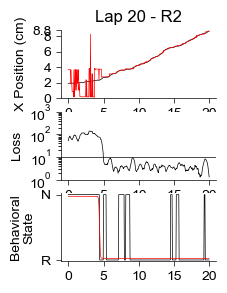

81.5


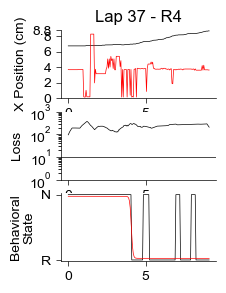

In [7]:
mouse = 10232
with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
    res = pickle.load(f)
    
def logistic_1_to_0(t, t0, k=1.0):
    # optional clipping for numerical safety if T is large
    z = k * (t - t0)
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(z))

def find_best_t0_manual(binary_seq, k=1.0):
    """
    binary_seq: 1D array-like, values in {0, 1}
                1 = non-retrieved, 0 = retrieved
    k: logistic steepness (default = 1)
    
    Returns:
        best_t0: t0 with minimum SSE
        candidate_t0s: array of all tested t0 values
        sse_values: SSE for each candidate t0
    """
    binary_seq = np.asarray(binary_seq, dtype=float)
    T = len(binary_seq)
    t = np.arange(-10, T+10)
    binary_seq_temp = np.concatenate([
        np.ones(10),
        binary_seq,
        np.ones(10)
    ]).astype(np.float64)
    binary_seq_temp = np.convolve(binary_seq_temp, np.ones(5)/5, mode='same')

    # t0 candidates: -0.5, 0.5, ..., T-1.5, T-0.5
    candidate_t0s = np.arange(-0.5, T + 0.5, 1.0)

    sse_values = []
    for t0 in candidate_t0s:
        pred = logistic_1_to_0(t, t0, k=k)
        sse = np.sum((binary_seq_temp - pred) ** 2)
        sse_values.append(sse)

    sse_values = np.array(sse_values)
    best_idx = np.argmin(sse_values)
    best_t0 = candidate_t0s[best_idx]

    return best_t0, candidate_t0s, sse_values
    
pos_traj = res['raw_pos_traj']
nodes_traj = res['raw_nodes_traj']
speed_traj = res['raw_speed_traj']
cumlen_traj = res['raw_cumlen_traj']
time_traj = res['raw_time_traj']
lap_traj = res['raw_lap_traj']
route_traj = res['raw_route_traj']
perfect_traj = res['raw_perfect_traj']
raw_traj = res['raw_traj']
decoded_nodes_traj = res['raw_decoded_nodes_traj'][0, :]
smoothed_loss_traj = res['raw_smoothed_loss_traj'][0, :]
retriv_state_traj = res['raw_retriv_state_traj']
hidden_state_traj = res['raw_hidden_state_traj']
session_traj = res['raw_session_traj']
print(hidden_state_traj.shape, route_traj.shape)

D = GetDMatrices(1, 48)
pred_x = D[decoded_nodes_traj-1, 0] / np.max(D) * 111
test_x = D[nodes_traj-1, 0] / np.max(D) * 111

beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(lap_traj)]))

for i in range(len(beg)):
    if session_traj[beg[i]] != 0:
        continue
    
    if route_traj[beg[i]] == 0:
        continue
    
    if i not in [19, 36]:
        continue
    
    fig, axes = plt.subplots(3, 1, figsize=(2, 3))
    ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax0.plot(time_traj[beg[i]:end[i]], test_x[beg[i]:end[i]], color='black', lw=0.5)
    ax0.plot(time_traj[beg[i]:end[i]], pred_x[beg[i]:end[i]], color='red', lw=0.5)
    ax0.set_ylabel('X Position (cm)')
    ax0.set_title(f"Lap {i+1} - R{route_traj[beg[i]]+1}")
    ax0.set_ylim(0, 110)
    ax0.set_yticks([0, 25, 50, 75, 100, 110], (0, 2, 4, 6, 8, 8.8))
    xlim = ax0.get_xlim()
    ax0.set_xticks(np.linspace(0, 100, 21))
    ax0.set_xlim(xlim[0], xlim[1])
    
    ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax1.plot(time_traj[beg[i]:end[i]], smoothed_loss_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax1.set_ylim(1, 1000)
    ax1.semilogy()
    ax1.axhline(10, color='k', lw=0.5)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Time (s)')
    ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
    ax1.set_xticks(np.linspace(0, 100, 21))
    ax1.set_xlim(xlim[0], xlim[1])
    
    ax2 = Clear_Axes(axes[2], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    t0 = find_best_t0_manual(hidden_state_traj[beg[i]:end[i]])[0]
    print(t0)
    y = logistic_1_to_0(np.arange(len(hidden_state_traj[beg[i]:end[i]])), t0)
    ax2.plot(time_traj[beg[i]:end[i]], hidden_state_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax2.plot(time_traj[beg[i]:end[i]], y*0.95+0.025, color='red', lw=0.5)
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_yticks(np.linspace(0, 1, 2), ['R', 'N'])
    ax2.set_ylabel('Behavioral\nState')
    ax2.set_xticks(np.linspace(0, 100, 21))
    ax2.set_xlim(xlim[0], xlim[1])
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.png"), dpi=600)
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.svg"), dpi=600)
    plt.show()

# Cross-Route Decoding

In [56]:
with open(join(dir_name, f"{10227}.pkl"), 'rb') as f:
    res = pickle.load(f)
    
pos_traj = res['raw_pos_traj']
nodes_traj = res['raw_nodes_traj']
speed_traj = res['raw_speed_traj']
cumlen_traj = res['raw_cumlen_traj']
time_traj = res['raw_time_traj']
lap_traj = res['raw_lap_traj']
route_traj = res['raw_route_traj']
perfect_traj = res['raw_perfect_traj']
raw_traj = res['raw_traj']
smoothed_loss_traj = res['raw_smoothed_loss_traj']
raw_final_map_traj = res['raw_final_map_traj']

father_nodes_traj = S2F[nodes_traj-1]

behav_params_templ_traj = res['behav_params_templ_traj']
behav_to_raw_traj = res['behav_to_raw_traj']
behav_params_traj = res['behav_params_traj']
raw_params_traj = behav_params_traj[:, behav_to_raw_traj]
raw_params_templ_traj = behav_params_templ_traj[:, behav_to_raw_traj]

behav_res_angles = raw_params_traj[4, :] - raw_params_templ_traj[2, :]
behav_res_angles[behav_res_angles > np.pi] = 2*np.pi - behav_res_angles[behav_res_angles > np.pi]
behav_res_angles[behav_res_angles < -np.pi] = -2*np.pi - behav_res_angles[behav_res_angles < -np.pi]

idx = np.where((np.isin(father_nodes_traj, CP_DSPs[1][0])) & (np.abs(behav_res_angles) <= np.pi/2))[0]
father_nodes_traj = father_nodes_traj[idx]
smoothed_loss_traj = smoothed_loss_traj[:, idx]
route_traj = route_traj[idx]
session_traj = res['raw_session_traj'][idx]
lap_traj = lap_traj[idx]
speed_traj = speed_traj[idx]
raw_final_map_traj = raw_final_map_traj[idx]
raw_rpos_traj = np.zeros(idx.shape[0], dtype=np.float64)

def func(rt):
    return np.where(CP_DSPs[1][0] == CP_DSPs[1][rt][0])[0][0] if rt in [0, 1, 2, 3] else np.where(CP_DSPs[1][0] == CP_DSPs[1][rt][rt-2])[0][0]

data = {
    'Route': route_traj,
    'R1-fitted Loss (cm)': smoothed_loss_traj[0, :],
    'R1 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(0),
    'R2-fitted Loss (cm)': smoothed_loss_traj[1, :],
    'R2 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(1),
    'R3-fitted Loss (cm)': smoothed_loss_traj[2, :],
    'R3 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(2),
    'R4-fitted Loss (cm)': smoothed_loss_traj[3, :],
    'R4 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(3),
    'R5-fitted Loss (cm)': smoothed_loss_traj[4, :],
    'R5 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(4),
    'R6-fitted Loss (cm)': smoothed_loss_traj[5, :],
    'R6 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(5),
    'R7-fitted Loss (cm)': smoothed_loss_traj[6, :],
    'R7 X': DSP_NRGs[1][0][father_nodes_traj-1] - func(6),
    'Speed (cm/s)': speed_traj,
    'Session': session_traj,
    'Lap': lap_traj,
    'map': raw_final_map_traj
}

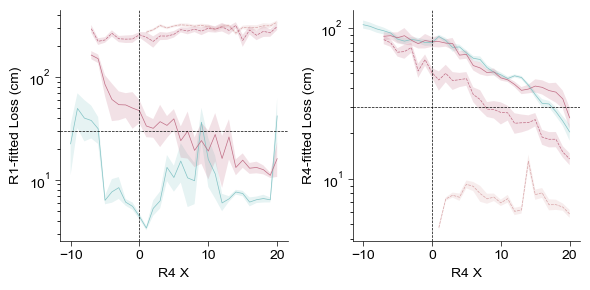

In [57]:
subdata = SubDict(data, data.keys(), np.where((data['R4 X'] <= 20) & (data['R4 X'] >= -10) & np.isin(data['Route'], [1, 3, 6]))[0])
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))
ax = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=subdata,
    x='R4 X',
    y='R1-fitted Loss (cm)',
    hue='Route',
    palette=[DSPPalette[1], DSPPalette[3], DSPPalette[6]],
    style='map',
    ax=ax,
    lw=0.5,
    legend=False,
    err_kws={'edgecolor': None}
)
ax.semilogy()
ax.axhline(30, color='k', lw=0.5, ls='--')
ax.axvline(0, color='k', lw=0.5, ls='--')
#ax.set_ylim(0, 3)
sns.lineplot(
    data=subdata,
    x='R4 X',
    y='R4-fitted Loss (cm)',
    hue='Route',
    palette=[DSPPalette[1], DSPPalette[3], DSPPalette[6]],
    style='map',
    ax=ax1,
    lw=0.5,
    legend=False,
    err_kws={'edgecolor': None}
)
ax1.semilogy()
ax1.axhline(30, color='k', lw=0.5, ls='--')
ax1.axvline(0, color='k', lw=0.5, ls='--')
#ax1.set_ylim(0, 3)
#plt.savefig(join(saved_dir, f"[10212] Proximity_Interation R3 R6.png"), dpi=600)
#plt.savefig(join(saved_dir, f"[10212] Proximity_Interation R3 R6.svg"), dpi=600)
plt.tight_layout()
plt.show()

# Lap-wise Loss Map Along the Track

        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Loss Maps is already existed!
        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Pretest GNB is already existed!
(192914,) (10, 143640) (118, 94510)
(0,)
10212:


100%|██████████| 548/548 [00:00<00:00, 27398.07it/s]


10212 (Pretest):


100%|██████████| 180/180 [00:00<00:00, 15003.17it/s]


(236629,) (10, 176107) (144, 115976)
(0,)
10224:


100%|██████████| 665/665 [00:00<00:00, 30225.86it/s]


10224 (Pretest):


100%|██████████| 281/281 [00:00<00:00, 21616.95it/s]


(281383,) (10, 209833) (302, 138490)
(0,)
10227:


100%|██████████| 609/609 [00:00<00:00, 27772.02it/s]

10227 (Pretest):



100%|██████████| 241/241 [00:00<00:00, 18539.81it/s]


(248448,) (10, 184862) (261, 121487)
(0,)
10232:


100%|██████████| 769/769 [00:00<00:00, 31784.42it/s]


10232 (Pretest):


100%|██████████| 382/382 [00:00<00:00, 18189.32it/s]
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:105: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:110: RuntimeWarning: divide by zero encountered in log10
  im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


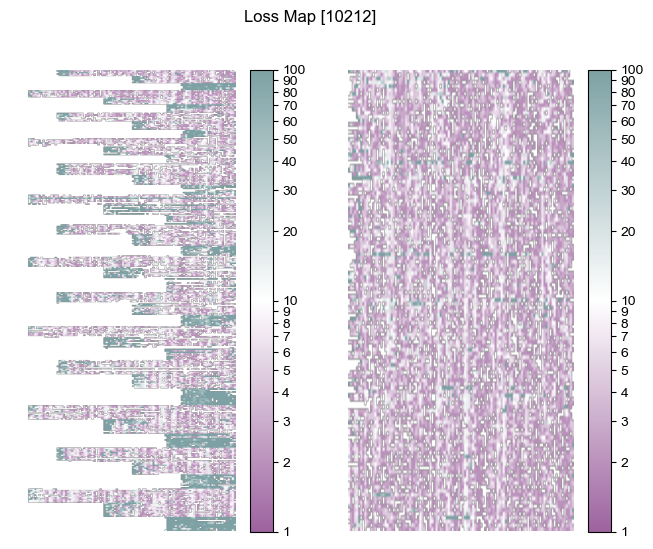

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:105: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:110: RuntimeWarning: divide by zero encountered in log10
  im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


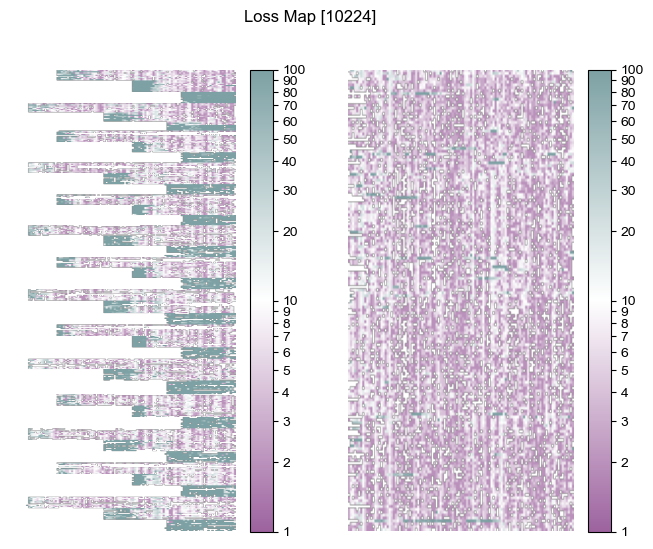

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:105: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:110: RuntimeWarning: divide by zero encountered in log10
  im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


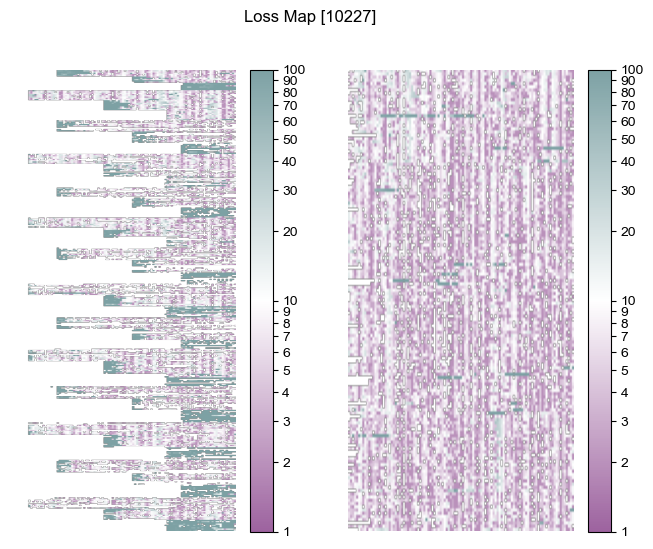

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:105: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_5236\780571469.py:110: RuntimeWarning: divide by zero encountered in log10
  im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


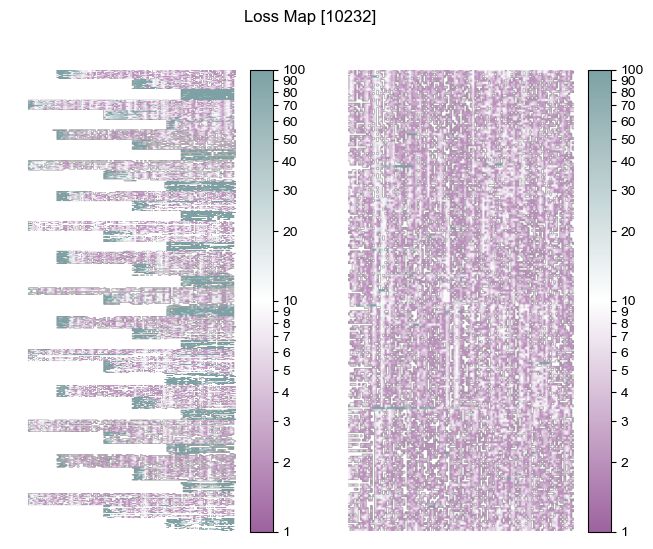

In [55]:
saved_dir_lossmap = join(loc, "Loss Maps")
mkdir(saved_dir_lossmap)

pretest_gnb_res_dir = join(loc, "Pretest GNB")
mkdir(pretest_gnb_res_dir)
if exists(join(saved_dir_lossmap, f" {10212} [Loss Map].pkl")) == False:
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
        
        nodes_traj = res['raw_nodes_traj']
        father_nodes_traj = S2F[nodes_traj - 1]
        behav_params_templ_traj = res['behav_params_templ_traj']
        behav_to_raw_traj = res['behav_to_raw_traj']
        behav_params_traj = res['behav_params_traj']
        raw_params_traj = behav_params_traj[:, behav_to_raw_traj]
        print(behav_to_raw_traj.shape, res['behav_params_traj'].shape, res['neural_traj'].shape)
        raw_params_templ_traj = behav_params_templ_traj[:, behav_to_raw_traj]

        behav_res_angles = raw_params_traj[4, :] - raw_params_templ_traj[2, :]
        behav_res_angles[behav_res_angles > np.pi] = 2*np.pi - behav_res_angles[behav_res_angles > np.pi]
        behav_res_angles[behav_res_angles < -np.pi] = -2*np.pi - behav_res_angles[behav_res_angles < -np.pi]

        idx = np.where((np.isin(father_nodes_traj, CP_DSPs[1][0])) & (np.abs(behav_res_angles) <= np.pi/4))[0]

        session_traj = res['raw_session_traj'][idx]
        lap_traj = res['raw_lap_traj'][idx]
        route_traj = res['raw_route_traj'][idx]

        time_traj = res['raw_time_traj'][idx]
        loss_traj = res['raw_loss_traj'][0, idx]
        print(np.where(np.isnan(loss_traj))[0].shape)
        smoothed_loss_traj = res['raw_smoothed_loss_traj'][0, idx]
        speed_traj = res['raw_speed_traj'][idx]
        raw_traj = res['raw_traj'][:, idx]
        nodes_traj = res['raw_nodes_traj'][idx]
        father_nodes_traj = S2F[nodes_traj - 1]

        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse}:")
        loss_map = []
        routes = []
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if rt in [0]:
                continue
            
            lmap = np.zeros(144, np.float64) * np.nan
            for j in range(beg[i], end[i]):
                if speed_traj[j] < 2.5:
                    continue
                lmap[father_nodes_traj[j]-1] = loss_traj[j]
            loss_map.append(lmap)
            routes.append(rt)
        
        loss_map = np.vstack(loss_map)[:, CP_DSPs[1][0]-1]
        routes = np.array(routes, dtype=np.int64)
        
        with open(join(saved_dir_lossmap, f"{mouse} [Loss Map].pkl"), 'wb') as f:
            pickle.dump([loss_map, routes], f)
            
        with open(join(pretest_gnb_res_dir, f"{mouse}.pkl"), 'rb') as f:
            pretest_res = pickle.load(f)
            
        loss_traj = pretest_res['loss_traj']
        smoothed_loss_traj = pretest_res['smoothed_loss_traj']
        session_traj = pretest_res['session_traj']
        nodes_traj = pretest_res['nodes_traj']
        father_nodes_traj = S2F[nodes_traj - 1]
        lap_traj = pretest_res['lap_traj']
        time_traj = pretest_res['time_traj']
        route_traj = np.repeat(0, len(lap_traj))
        
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse} (Pretest):")
        loss_map = []
        routes = []
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if session_traj[beg[i]] <9:
                continue
            if rt in [0]:
                lmap = np.zeros(144, np.float64) * np.nan
                for j in range(beg[i], end[i]):
                    lmap[father_nodes_traj[j]-1] = loss_traj[j]
                loss_map.append(lmap)
                routes.append(rt)
        loss_map = np.vstack(loss_map)[:, CP_DSPs[1][0]-1]
        routes = np.array(routes, dtype=np.int64)
        with open(join(saved_dir_lossmap, f"{mouse} [Loss Map Pretest].pkl"), 'wb') as f:
            pickle.dump([loss_map, routes], f)


for mouse in [10212, 10224, 10227, 10232]:
    with open(join(saved_dir_lossmap, f"{mouse} [Loss Map].pkl"), 'rb') as f:
        loss_map, routes = pickle.load(f)

    with open(join(saved_dir_lossmap, f"{mouse} [Loss Map Pretest].pkl"), 'rb') as f:
        loss_map_pretest, routes_pretest = pickle.load(f)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
    ax0 = Clear_Axes(axes[0])
    im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ax=ax0)
    cbar.set_ticks(np.log10(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])), 
                   labels=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    ax1 = Clear_Axes(axes[1])
    im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_ticks(np.log10(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])), 
                   labels=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    plt.suptitle(f"Loss Map [{mouse}]")
    plt.savefig(join(saved_dir, f"Loss Map [{mouse}].png"), dpi=600)
    plt.savefig(join(saved_dir, f"Loss Map [{mouse}].svg"), dpi=600)
    plt.show()

# GNB Decoding on pretest data.

In [31]:
pretest_gnb_res_dir = join(loc, "Pretest GNB")
mkdir(pretest_gnb_res_dir)
def get_lapwise_nb_loss_pretest(mouse: int):
    if mouse in [10212]:
        file_idx = np.where(
            (f1['MiceID'] == mouse) &
            (f1['maze_type'] == 1) &
            (f1['Stage'] == 'Stage 1')
        )[0]
        print(len(file_idx))
    elif mouse in [10224, 10227, 10232]:
        file_idx = np.where(
            (f1['MiceID'] == mouse) &
            (f1['maze_type'] == 1) &
            (f1['Stage'] == 'Stage 2')
        )[0]
        print(len(file_idx))
    else:
        raise NotImplementedError(f"Mouse {mouse} not in the pretest group.")
    
    res = {
        "loss_traj": [],
        "smoothed_loss_traj": [],
        "session_traj": [],
        "nodes_traj": [],
        "time_traj": [],
        "lap_traj": [],
    }
    D = GetDMatrices(1, 48)
    for i in range(6, len(file_idx)):
        with open(f1['Trace File'][file_idx[i]], 'rb') as ff:
            trace = pickle.load(ff)
            
        print(f"{trace['MiceID']} ------ S{i+1} ------")
        print(DateTime())
        print(trace.keys())
            
        idx = np.where(
            np.isin(trace['ms_time'], trace['ms_time_behav'])
        )[0]
        
        assert idx.shape[0] == trace['ms_time_behav'].shape[0], "Mismatch in time indices."
        
        RawSpikes = np.where(
            trace['RawTraces'] - np.std(trace['RawTraces'], axis=1, keepdims=True)*3 >= 0, 1, 0
        )
        RawSpikes = RawSpikes[:, idx]
        spike_nodes = trace['spike_nodes_original'][idx].astype(np.int64)
        ms_time_behav = trace['ms_time_behav']
        
        
        lap_beg_time, lap_end_time = trace['lap beg time'], trace['lap end time']
        for j in range(len(lap_beg_time)):
            print(f"   Lap {j+1}:")
            train_idx = np.where(
                (ms_time_behav < lap_beg_time[j]) | 
                (ms_time_behav > lap_end_time[j])
            )[0]
            test_idx = np.where(
                (ms_time_behav >= lap_beg_time[j]) & 
                (ms_time_behav <= lap_end_time[j])
            )[0]
            
            model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
            model.fit(RawSpikes[:, train_idx], spike_nodes[train_idx])
            y_pred = model.predict(Spikes_test=RawSpikes[:, test_idx], MazeID_test=spike_nodes[test_idx]).astype(np.int64)
            y_test = spike_nodes[test_idx].astype(np.int64)
            loss_traj = D[(y_pred-1, y_test-1)]
            smoothed_loss_traj = np.convolve(loss_traj, np.ones(10)/10, mode='same')
            res['loss_traj'].append(loss_traj)
            res['smoothed_loss_traj'].append(smoothed_loss_traj)
            res['session_traj'].append(np.ones_like(loss_traj, dtype=np.int64) * i)
            res['nodes_traj'].append(y_test)
            res['time_traj'].append(ms_time_behav[test_idx])
            res['lap_traj'].append(np.ones_like(loss_traj, dtype=np.int64) * (j+1))
            
    for key in res.keys():
        res[key] = np.concatenate(res[key])
        
    with open(join(pretest_gnb_res_dir, f"{mouse}.pkl"), 'wb') as f:
        pickle.dump(res, f)
    
    print(DateTime())
    print("Saved ---------", end="\n\n\n")
    
#get_lapwise_nb_loss_pretest(10212)
#get_lapwise_nb_loss_pretest(10224)
#get_lapwise_nb_loss_pretest(10227)
#get_lapwise_nb_loss_pretest(10232)

        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Pretest GNB is already existed!
